### Initial configuration

In [1]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last'

In [61]:
plt.rcParams['figure.figsize'] = (5,4)

## Moment of inertia

### Initial conditions

In [83]:
E = 1

vertices = list(zip(
    (0, 15, 15, 10, 10, 5, 5, 0), #x-координаты вершин
    (0, 0, 5, 5, 10, 10, 5, 5) #y-координаты вершин
    ))
# vertices = [tuple(smp.S(num) for num in vertex) for vertex in vertices] #float -> sympy
vertices.append(vertices[0]) #замыкает многоугольник

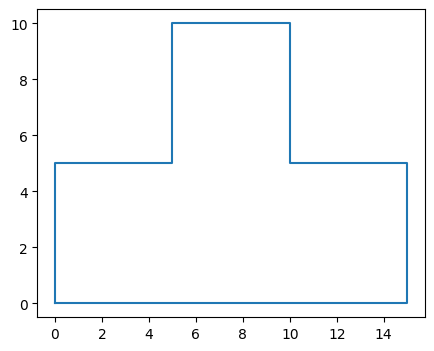

In [84]:
fig, ax = plt.subplots()
ax.plot(*zip(*vertices))
plt.show()

### Moments of area

In [90]:
A = np.abs(sum(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1] for i in range(len(vertices)-1))/2) #площадь
c = (
    np.abs(sum((vertices[i][0] + vertices[i+1][0])*(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1]) for i in range(len(vertices)-1))/(6*A)),
    np.abs(sum((vertices[i][1] + vertices[i+1][1])*(vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1]) for i in range(len(vertices)-1))/(6*A))
    ) #координаты центра масс
Jx = np.abs(sum((vertices[i][0]*vertices[i+1][1] - vertices[i+1][0]*vertices[i][1])*(vertices[i][0]**2 + vertices[i][0]*vertices[i+1][0] + vertices[i+1][0]**2) for i in range(len(vertices)-1))/12) #момент инеции относительно x
Jcx = Jx - A*c[1]**2 #момент инерции относительно оси, параллельной x и проходящей через центр масс

In [91]:
A, c, Jcx

(100.0, (7.5, 3.75), 5677.083333333333)

## Internal forces

### Initial conditions

In [2]:
eps = smp.symbols('varepsilon', positive=True)

parameters = smp.symbols('q0 a', positive=True) #параметры. Символы y0, dy0, N, t зарезервированы
q0, a = parameters
parameter_values = [1, 1] #значения параметров если даны, иначе None

x = smp.symbols('x')

In [3]:
l = a #длина балки
x_rigid = [0] #точки жёсткого крепления
x_hinge = [l] #точки шарнирного крепления
q = smp.Piecewise((q0, (0 <= x) & (x < a)), (0, True)) #распределённая сила
F, xF = [], [] #силы и точки их приложения кроме реакций опор
t, xt = [], [] #моменты сил и точки их приложения кроме реакций опор

In [4]:
y0, dy0 = smp.symbols('y0, dy0') #y и y' при x = 0
N_base, t_base = smp.IndexedBase('N'), smp.IndexedBase('t') #силы и моменты реакций опор

F_contact = [N_base[i] for i in range(len(x_rigid) + len(x_hinge))]
F.extend(F_contact)
xF.extend(x_rigid + x_hinge)
t_contact = [t_base[i] for i in range(len(x_rigid))]
t.extend(t_contact)
xt.extend(x_rigid)

variables = (y0, dy0, *F_contact, *t_contact)

In [5]:
display(smp.Tuple(F, xF))
display(smp.Tuple(t, xt))

([N[0], N[1]], [0, a])

([t[0]], [0])

### Integration

In [6]:
funcs = {}
funcs['Q'] = smp.integrate(q, (x,0,x)) + sum(Fi*smp.Heaviside(x-xi) for Fi, xi in zip(F, xF))
funcs['M'] = (-smp.integrate(funcs['Q'], (x,0,x)) + sum(ti*smp.Heaviside(x-xi) for ti, xi in zip(t, xt)))
funcs['dy'] = (dy0 + smp.integrate(funcs['M'], (x,0,x)))
funcs['y'] = (y0 + smp.integrate(funcs['dy'], (x,0,x)))

funcs = {func_name: smp.piecewise_fold(func.rewrite(smp.Piecewise)).simplify() for func_name, func in funcs.items()}

In [7]:
display(*funcs.values())

Piecewise((0, x < 0), (N[0]/2, Eq(x, 0)), (q0*x + N[0], a > x), (q0*x + N[0] + N[1]/2, Eq(a, x)), (a*q0 + N[0] + N[1], True))

Piecewise((0, x < 0), (a**2*q0/2 - a*q0*x + a*N[1] - x*N[0] - x*N[1] + t[0], a <= x), (t[0]/2, Eq(x, 0)), (-q0*x**2/2 - x*N[0] + t[0], True))

Piecewise((dy0, x < 0), (-a**3*q0/6 + a**2*q0*x/2 - a**2*N[1]/2 - a*q0*x**2/2 + a*x*N[1] + dy0 - x**2*N[0]/2 - x**2*N[1]/2 + x*t[0], a <= x), (dy0 - q0*x**3/6 - x**2*N[0]/2 + x*t[0], True))

Piecewise((dy0*x + y0, x < 0), (a**4*q0/24 - a**3*q0*x/6 + a**3*N[1]/6 + a**2*q0*x**2/4 - a**2*x*N[1]/2 - a*q0*x**3/6 + a*x**2*N[1]/2 + dy0*x - x**3*N[0]/6 - x**3*N[1]/6 + x**2*t[0]/2 + y0, a <= x), (dy0*x - q0*x**4/24 - x**3*N[0]/6 + x**2*t[0]/2 + y0, True))

### Solving for contact forces

In [8]:
eq_system = [
    funcs['Q'].subs(x, l+eps).subs(eps, 0), #сумма всех сил
    funcs['M'].subs(x, l+eps).subs(eps, 0), #сумма всех моментов сил
    *[funcs['y'].subs(x, coord) for coord in x_rigid + x_hinge], #условия крепления
    *[funcs['dy'].subs(x, coord) for coord in x_rigid]
]

In [9]:
display(*eq_system)

a*q0 + N[0] + N[1]

-a**2*q0/2 - a*N[0] + t[0]

y0

-a**4*q0/24 - a**3*N[0]/6 + a**2*t[0]/2 + a*dy0 + y0

dy0

In [10]:
solution = smp.linsolve(eq_system, *variables)
assert len(solution) == 1, 'Решение не единственно'
variable_values = list(solution)[0]
display(smp.Tuple(*variables))
display(variable_values)

(y0, dy0, N[0], N[1], t[0])

(0, 0, -5*a*q0/8, -3*a*q0/8, -a**2*q0/8)

### Variables substitution

In [11]:
funcs_var_subs = {func_name: func.subs(zip(variables, variable_values)) for func_name, func in funcs.items()}

In [12]:
display(*funcs_var_subs.values())

Piecewise((0, x < 0), (-5*a*q0/16, Eq(x, 0)), (-5*a*q0/8 + q0*x, a > x), (-13*a*q0/16 + q0*x, Eq(a, x)), (0, True))

Piecewise((0, (a <= x) | (x < 0)), (-a**2*q0/16, Eq(x, 0)), (-a**2*q0/8 + 5*a*q0*x/8 - q0*x**2/2, True))

Piecewise((0, x < 0), (a**3*q0/48, a <= x), (-a**2*q0*x/8 + 5*a*q0*x**2/16 - q0*x**3/6, True))

Piecewise((0, x < 0), (-a**4*q0/48 + a**3*q0*x/48, a <= x), (-a**2*q0*x**2/16 + 5*a*q0*x**3/48 - q0*x**4/24, True))

### Parameters substitution

In [17]:
assert parameter_values is not None, 'Параметры не заданы'
funcs_param_subs = {func_name: func.subs(zip(parameters, parameter_values)) for func_name, func in funcs_var_subs.items()}
l_subs = l.subs(zip(parameters, parameter_values))

In [16]:
display(*funcs_param_subs.values())

Piecewise((0, x < 0), (-5/16, Eq(x, 0)), (x - 5/8, x < 1), (x - 13/16, Eq(x, 1)), (0, True))

Piecewise((0, (x >= 1) | (x < 0)), (-1/16, Eq(x, 0)), (-x**2/2 + 5*x/8 - 1/8, True))

Piecewise((0, x < 0), (1/48, x >= 1), (-x**3/6 + 5*x**2/16 - x/8, True))

Piecewise((0, x < 0), (x/48 - 1/48, x >= 1), (-x**4/24 + 5*x**3/48 - x**2/16, True))

## Final results

### Plotting

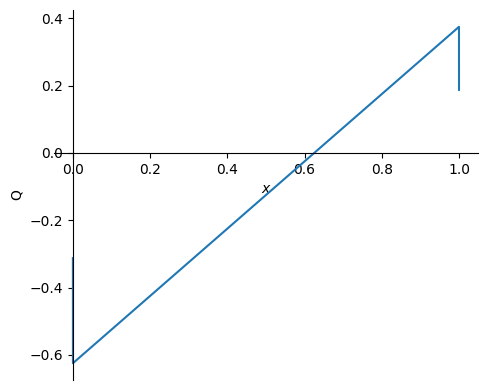

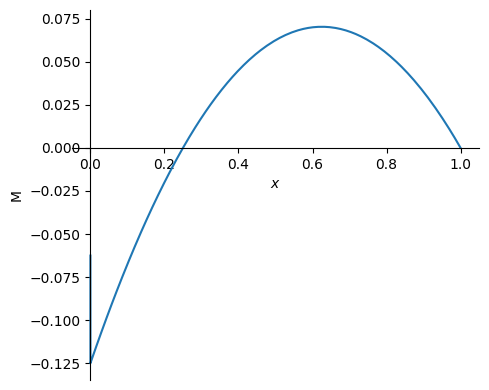

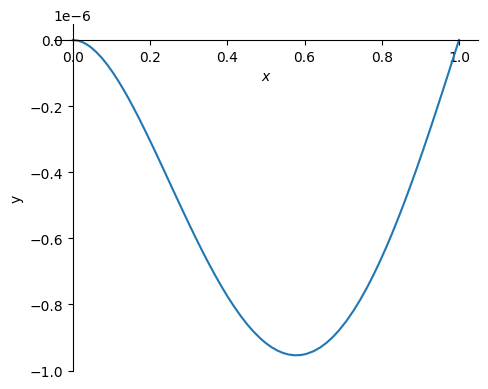

In [92]:
smp.plotting.plot(funcs_param_subs['Q'], (x,0,l_subs), ylabel='Q')
plt.show()
smp.plotting.plot(funcs_param_subs['M'], (x,0,l_subs), ylabel='M')
plt.show()
smp.plotting.plot(funcs_param_subs['y']/E/Jcx, (x,0,l_subs), ylabel='y')
plt.show()

In [38]:
funcs_vect = {func_name: np.vectorize(smp.lambdify(x, func)) for func_name, func in funcs_param_subs.items()}

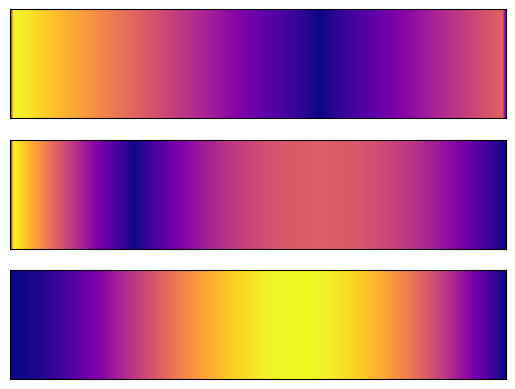

In [40]:
fig, axes = plt.subplots(3,1)
xp = np.linspace(0,float(l_subs),200)
xp = np.vstack((xp, xp))
for ax, func in zip(axes, (funcs_vect['Q'], funcs_vect['M'], funcs_vect['y'])):
    ax.imshow(np.abs(func(xp)), aspect='auto', cmap='plasma')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()